# Prepare

In [1]:
import torch
import numpy as np
import random
from torch.backends import cudnn

**Set the seed. Let the result can be Reproducible**

In [2]:
seed = 20

# set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.deterministic = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

# Data Define

In [4]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import os
import torch

## MyData class Define

In [5]:
class MyData(Dataset):

    def __init__(self, csv_file, data_dir, transform=None):
        self.desc = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform
        print(self.transform)

    def __len__(self):
        return len(self.desc)

    def __getitem__(self, item):
        path = os.path.join(self.data_dir, self.desc.iloc[item, 0])
        x = np.load(path)[0]

        if self.transform is not None:
            x = self.transform(x)

        label = torch.tensor(self.desc.iloc[item, 1])
        return x, label

## Create Data Description

The file organization of this task dataset should be as follows:

****
```
DeepLens-Test
  |-- CommonTest
     |-- dataset
        |-- train
           |-- no
           |-- sphere
           |-- vort
        |-- val
           |-- no
           |-- sphere
           |-- vort
        |-- test description.csv
        |-- train description.csv
        |-- val description.csv
```
****

`train description.csv` `test description.csv` and `val description.csv` is generate by program. I have provided it. Dataset can be get <a href="https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view">here</a>.

In [6]:
def index_of_class(classname):
    if classname == "no":
        return 0
    elif classname == "sphere":
        return 1
    elif classname == "vort":
        return 2
    else:
        raise Exception("unknown class name!")


def create_train_description(data_dir, train_rate=0.9, need_num=None):
    """create a description csv file. see "./dataset/train description.csv",
    "./dataset/val description.csv". Some demo example can be find in demo.py

    Args:
        data_dir:
            root directory of train or val dataset. Here,
            it should be "./dataset/train"
        train_rate:
            rate of train set
        need_num:
            set the numbers of samples you need.
    """
    class_dirs = os.listdir(data_dir)
    line_train = "path,label\n"
    line_val = "path,label\n"
    for class_dir in class_dirs:
        samples = os.listdir(os.path.join(data_dir, class_dir))[:need_num]

        # split train set to train and val
        end_idx = int(train_rate * len(samples))
        random.shuffle(samples)
        train_samples = samples[:end_idx]
        val_samples = samples[end_idx:]

        for sample in train_samples:
            line_train += os.path.join(class_dir, sample) + "," + str(index_of_class(class_dir)) + "\n"

        for sample in val_samples:
            line_val += os.path.join(class_dir, sample) + "," + str(index_of_class(class_dir)) + "\n"

    store_path = os.path.join("./dataset", "train description.csv")
    with open(store_path, "w") as f:
        f.write(line_train)

    if train_rate != 1:
        store_path = os.path.join("./dataset", "val description.csv")
        with open(store_path, "w") as f:
            f.write(line_val)


def create_test_description(data_dir, need_num=None):
    """create a description csv file. see "./dataset/test description.csv".
    Some demo example can be find in demo.py

    Args:
        data_dir:
            root directory of train or val dataset. Here,
            it should be "./dataset/val"
        need_num:
            set the numbers of samples you need.
    """
    class_dirs = os.listdir(data_dir)

    line = "path,label\n"
    for class_dir in class_dirs:
        samples = os.listdir(os.path.join(data_dir, class_dir))[:need_num]

        for sample in samples:
            line += os.path.join(class_dir, sample) + "," + str(index_of_class(class_dir)) + "\n"

    store_path = os.path.join("./dataset", "test description.csv")
    with open(store_path, "w") as f:
        f.write(line)

**run once is ok. If description files already exist, do not run this part.**

In [7]:
# create_train_description("./dataset/train")
# create_test_description("./dataset/val")

# Model Define

In [8]:
from torch import nn
from torchvision import models
from torch.nn import Conv2d

This dataset is not complicated. So, simple deep model such as AlexNet, VGG, ResNet, DenseNet can be competent at this task. According to paper[1], for ResNet, the defining feature is that residual networks can skip layers all together in training. This helps speed up the learning rate of the network by allowing the network to train fewer layers in the initial stages of learning. ResNet is more computationally efficient than both VGG and DenseNet. Here, we use ResNet18.

Many tasks have been benefit from transfer learning. Transfer learning can speed up the time of training models by reusing modules or parts of pretrained models. This not only speeds up the model training process, but also improves the training effect. By transfer learning, we use the pretrained ResNet18 on ImageNet as backbone. The we add a three layers mlp as a simple classifier. The model architecture look like this:

<center><img src="https://cdn.jsdelivr.net/gh/AllenWrong/BlogCDN/img/res arch.png" max-witdh="50%" max-height="50%"/></center>

**[1]** Deep Learning the Morphology of Dark Matter Substructure

In [9]:
class ResNetClf(nn.Module):

    def __init__(self, pre_trained):
        """
        Args:
            pre_trained: True if want to use pretrained weight else false
        """
        super(ResNetClf, self).__init__()
        self.backbone = models.resnet18(pretrained=pre_trained)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
        self.backbone.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone.fc = self.classifier

    def forward(self, x):
        return self.backbone(x)

# Training

- **data augmentation:** According paper[1], during training I use the data augmengtation via random translation and random rotation.


- **batch_size:** I have tried batch_size=200, batch_size=64, batch_size=128. Results show that batch_size=128 same a better choice. Larger batch_size can improve the computational efficiency through the matrix multiply. More larger batch_size reduces the number of iterations required to compute all the training set, so the time required to achieve the same accuracy becomes larger, and the adjust of parameters becomes slow.


- **num_epoch:** 50


- **lr:** According to paper[1], I set the lr with value of 1e-4. If the AUC does not increase for four consecutive epochs, the learning rate will be multiplied by 0.7 to decay.


- **train:** When one epoch has finished, model will evaluate it's current performance on the validation dataset.  


**Final auc is 98.95%, acc is 92.87%**, which is an acceptable result.

**[1]** Deep Learning the Morphology of Dark Matter Substructure

## Training Config Define

In [10]:
class Config:
    num_epochs = 50
    batch_size = 128
    # reference from paper "Deep Learning the Morphology of Dark Matter Substructure"
    lr = 1e-4

## Import Package

In [11]:
import torch.optim as optim
from utils import check_accuracy, save_checkpoint
import torch.nn as nn
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import sys
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

## Train Function Define

In [12]:
def train_fn(cfg, train_loader, val_loader, model, optimizer, criterion, need_flatten=False):
    """
    train function
    """

    acc_per_epoch = []
    max_auc = 0.0

    # lr scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.8,
        patience=4,
        threshold=0.001,
        min_lr=1e-5,
        verbose=True
    )

    for epoch in range(cfg.num_epochs):
        losses_per_batch = []
        start_time = time.time()

        # mini batch training
        p_bar = tqdm(enumerate(train_loader), leave=False, total=len(train_loader), file=sys.stdout)
        for batch_idx, (x_batch, y_batch) in p_bar:
            # move data to gpu if cuda is available
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            if need_flatten:
                x_batch = x_batch.reshape(x_batch.shape[0], -1)

            # forward
            scores = model.forward(x_batch)
            loss = criterion(scores, y_batch)
            losses_per_batch.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent step
            optimizer.step()

        # compute acc and loss
        cur_acc, auc, _, _ = check_accuracy(val_loader, model, device, need_flatten)
        mean_loss = sum(losses_per_batch) / len(losses_per_batch)
        acc_per_epoch.append(cur_acc)

        # lr scheduler
        scheduler.step(auc)

        # save model
        if epoch >= 20 and auc > max_auc:
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            print(f"epoch: [{epoch + 1}/{cfg.num_epochs}], ", end="")
            save_checkpoint(checkpoint, "./checkpoint/best_auc_model.pth.tar")
            max_auc = auc

        # print log
        end_time = time.time()
        print(f"epoch: [{epoch + 1}/{cfg.num_epochs}], "
              f"loss: {mean_loss:.8f}, "
              f"val acc: {cur_acc.item():.4f}, "
              f"val auc: {auc:.4f}, "
              f"time used: {(end_time - start_time)/60:.4f}m")

## Train Model

In [13]:
# create a config
cfg = Config()

### Data Prepare

In [14]:
train_dir = "./dataset/train"
val_dir = "./dataset/train"
test_dir = "./dataset/val"

train_desc_dir = "./dataset/train description.csv"
val_desc_dir = "./dataset/val description.csv"
test_desc_dir = "./dataset/test description.csv"

# transform
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomAffine(degrees=(0, 180), translate=(0.2, 0.2)),
        transforms.Resize((150, 150))
    ])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150))
])

In [15]:
train_set = MyData(train_desc_dir, train_dir, transform=train_transform)
val_set = MyData(val_desc_dir, val_dir, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=cfg.batch_size, pin_memory=True)

Compose(
    ToTensor()
    RandomAffine(degrees=[0.0, 180.0], translate=(0.2, 0.2))
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
)
Compose(
    ToTensor()
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
)


### Train

In [16]:
if not os.path.exists("checkpoint"):
    os.makedirs("checkpoint")

In [17]:
model = ResNetClf(True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

train_fn(cfg, train_loader, val_loader, model, optimizer, criterion)

epoch: [1/50], loss: 1.09917662, val acc: 0.3860, val auc: 0.5597, time used: 5.7564m
epoch: [2/50], loss: 1.07380610, val acc: 0.4153, val auc: 0.6187, time used: 5.7530m
epoch: [3/50], loss: 0.95937999, val acc: 0.4490, val auc: 0.6858, time used: 5.7555m
epoch: [4/50], loss: 0.82470558, val acc: 0.5893, val auc: 0.7934, time used: 5.7500m
epoch: [5/50], loss: 0.71235942, val acc: 0.7147, val auc: 0.8870, time used: 5.7498m
epoch: [6/50], loss: 0.62316861, val acc: 0.7057, val auc: 0.8833, time used: 5.7506m
epoch: [7/50], loss: 0.54778413, val acc: 0.7553, val auc: 0.9157, time used: 5.7513m
epoch: [8/50], loss: 0.49973536, val acc: 0.8123, val auc: 0.9439, time used: 5.7525m
epoch: [9/50], loss: 0.46813309, val acc: 0.8207, val auc: 0.9498, time used: 5.7574m
epoch: [10/50], loss: 0.43722969, val acc: 0.8443, val auc: 0.9578, time used: 5.7484m
epoch: [11/50], loss: 0.41298067, val acc: 0.7997, val auc: 0.9449, time used: 5.7475m
epoch: [12/50], loss: 0.38993755, val acc: 0.8263, v

# Evaluation 

In [18]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from utils import check_accuracy, load_checkpoint, plot_roc
from sklearn.metrics import roc_curve

In [19]:
# create a config
cfg = Config()

## Test Data Prepare

**You can get pretrained weight <a href="https://drive.google.com/file/d/1CVxOc0YovdcNGguXcSXneIFS9Gy9CnHz/view?usp=sharing">here</a>**

**After downloading it, add it to the directory "./checkpoint". Then you can perform the evaluation.**

In [20]:
testset_dir = "./dataset/val"
testdesc_dir = "./dataset/test description.csv"
pretrained_model = "./checkpoint/best_auc_model.pth.tar"

test_tranform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150))
])

test_set = MyData(testdesc_dir, testset_dir, transform=test_tranform)
test_loader = DataLoader(test_set, batch_size=cfg.batch_size)

Compose(
    ToTensor()
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
)


In [21]:
model = ResNetClf(False).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
load_checkpoint(pretrained_model, model, optimizer)

====> Load model from ./checkpoint/best_auc_model.pth.tar


acc: 0.9286666666666668, auc: 0.98946832


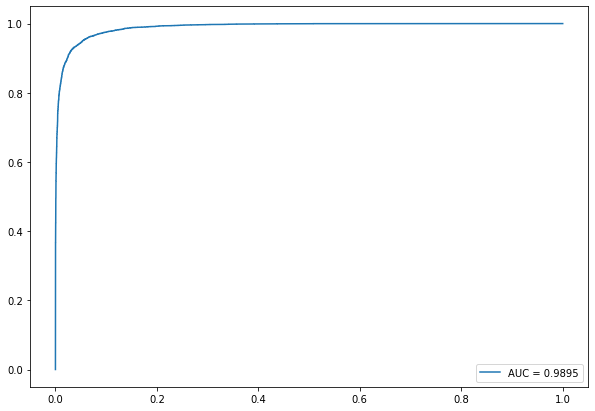

In [22]:
acc, auc, y_true, y_pred = check_accuracy(test_loader, model, device)
print(f"acc: {acc.item()}, auc: {auc}")

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plot_roc(fpr, tpr, auc)